# Online Joint State and Parameters Estimation for AR SSM 
State space model
\begin{align*}
    &\mathbf{x}_t = \mathbf{A}\mathbf{x}_{t-1} + \mathbf{p}_t \quad \mathbf{p}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{I}\gamma_x^{-1}) \\
    &y_t = \mathbf{c}^\text{T}\mathbf{x}_t + m_t \quad v_t \sim \mathcal{N}(0, \gamma_y^{-1})
\end{align*}

or

\begin{align*}
     &p(\mathbf{x}_t\,|\,\mathbf{x}_{t-1},\mathbf{a},\gamma) = \mathcal{N}\left(\mathbf{x}_t\;\middle|\; \mathbf{A}\mathbf{x}_{t-1},  \mathbf{I}\gamma_x^{-1} \right)\\
    &p(y_t\,|\,\mathbf{x}_{t}) = \mathcal{N}\left(y_t \;\middle|\;\mathbf{c}^\text{T}\mathbf{x}_t, \gamma_y^{-1} \right)
\end{align*}

where
\begin{align*}
    &\mathbf{x}_t = (x_t, x_{t-1}, \dots, x_{t-p+1})^\text{T} \quad \mathbf{x}_{t-1} = (x_{t-1}, x_{t-2}, \dots, x_{t-p})^\text{T} 
    \\ \\
    &\mathbf{A} = 
    \begin{bmatrix}
        a_1 & a_2 & a_3 & \dots & a_p \\
        1 & 0 & 0 & \dots & 0 \\ 
        0 & 1 & 0 & \dots & 0 \\   
        \vdots & \vdots & \vdots & \ddots & \vdots \\
        0 & 0 & 0 & \dots & 0
    \end{bmatrix}
    =
    \begin{bmatrix}
         \mathbf{a}^\text{T} \\
         \mathbf{I}_{p-1} \quad \mathbf{0}
    \end{bmatrix}
    \\ \\
    &\mathbf{I} = \mathbf{I}_p = 
    \begin{bmatrix}
        1 & 0 & 0 & \dots & 0 \\ 
        0 & 1 & 0 & \dots & 0 \\   
        \vdots & \vdots & \vdots & \ddots & \vdots \\
        0 & 0 & 0 & \dots & 1
    \end{bmatrix} \\
\end{align*}

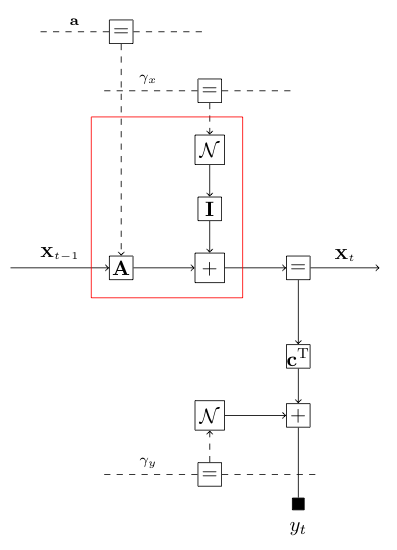

In [226]:
using Images
img = load("../ffgs/HAR-online.png")

The central quantity of our interest is a joint estimation of the AR coefficients $\mathbf{a}$, precision of process noise $\gamma_x$ and states $\mathbf{x}_n$, while setting measurement noise precisions $\gamma_y=1$.

In [83]:
using ProgressMeter
using Revise
using ForneyLab
include( "../AR-node/autoregression.jl")
include("../AR-node/rules_prototypes.jl")
include("../AR-node/vmp_rules.jl")
include( "../AR-node/observationAR.jl")
# helpers for evaluation of the model
include("../helpers/functions.jl")
# module to generate data for AR
include("../data/ARdata.jl")
import Main.ARdata: use_data, generate_data, generate_sin
import LinearAlgebra.I, LinearAlgebra.Symmetric
import ForneyLab: unsafeCov, unsafeMean, unsafePrecision

In [84]:
ARorder = 2 # order of AR model
diagAR(dim) = Matrix{Float64}(I, dim, dim)
x = []
# AR data
a = 1.0; b = 1.0
γ_x = b/a # process noise variance
coefs, x = generate_data(1000, ARorder, 1, noise_variance=γ_x^-1)
#x = use_data("../data/temperature.csv", ARorder)
coefs, x = generate_sin(1000, tiny)
γ_y = 1.0 # measurement noise variance
# Observations
y = [xi[1] + sqrt(γ_y)*randn() for xi in x[ARorder:end]]

999-element Array{Float64,1}:
 -1.4948675263380276  
 -0.7532391847580094  
 -1.6685956291781752  
  0.8776090713974537  
  3.013038368757913   
  0.014508045085720012
 -1.835507216020014   
  0.4428662650085815  
 -0.798894234199612   
  0.1174108956888551  
 -0.4300776992987392  
  0.5544059239176723  
  0.14514405127046515 
  ⋮                   
  0.3044862360401023  
 -2.6929416556962282  
  0.179718807683947   
  0.08900308823442571 
  0.5048726772476417  
  1.132632871805558   
  0.6884288054502063  
 -0.38721866974202057 
 -0.5045302182496278  
  0.11733911943997465 
  1.8537616658575722  
 -0.5719480241808848  

In [85]:
# Building the model
g = FactorGraph()

# declare priors as random variables
@RV m_x_t_prev
@RV w_x_t_prev
@RV m_a
@RV w_a
@RV m_y_t
@RV w_y_t
@RV a_w
@RV b_w

@RV a ~ GaussianMeanPrecision(m_a, w_a)
@RV x_t_prev ~ GaussianMeanPrecision(m_x_t_prev, w_x_t_prev)
@RV w ~ Gamma(a_w, b_w)
@RV x_t = AR(a, x_t_prev, w)
observationAR(m_y_t, x_t, w_y_t)

# Placeholders for prior
placeholder(m_a, :m_a, dims=(ARorder,))
placeholder(w_a, :w_a, dims=(ARorder, ARorder))

# Placeholder for data
placeholder(m_x_t_prev, :m_x_t_prev, dims=(ARorder,))
placeholder(w_x_t_prev, :w_x_t_prev, dims=(ARorder, ARorder))
placeholder(a_w, :a_w)
placeholder(b_w, :b_w)
placeholder(m_y_t, :m_y_t)
placeholder(w_y_t, :w_y_t)

ForneyLab.draw(g)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 10057053299720427476 -->
 
 10057053299720427476 
 
 placeholder_w_y_t 
 
<!-- 14100081550386088055 -->
 
 14100081550386088055 
 
 observationAR 
 observationar_1 
 
<!-- 10057053299720427476--14100081550386088055 -->
 
 10057053299720427476--14100081550386088055 
 
 w_y_t 
 3 z 
 1 out 
 
<!-- 15833220019104528709 -->
 
 15833220019104528709 
 
 placeholder_m_x_t_prev 
 
<!-- 5287204053876432257 -->
 
 5287204053876432257 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 15833220019104528709--5287204053876432257 -->
 
 15833220019104528709--5287204053876432257 
 
 m_x_t_prev 
 2 m 
 1 out 
 
<!-- 10325157394719826762 -->
 
 10325157394719826762 
 
 Gam 
 gamma_1 
 
<!-- 17322423618854593098 -->
 
 17322423618854593098 
 
 placeholder_b_w 
 
<!-- 17322423618854593098--10325157394719826762 -->
 
 17322423618854593098--10325157394719826762 
 
 b_w 
 3 b 
 1 out 
 
<!-- 12222761472070952755 -->
 
 12222761472070952755 
 
 placeholder_a_w 
 
<!-- 12222761472070952755--10325157394719826762 -->
 
 12222761472070952755--10325157394719826762 
 
 a_w 
 2 a 
 1 out 
 
<!-- 4262965481255855637 -->
 
 4262965481255855637 
 
 Autoregression 
 autoregression_1 
 
<!-- 4262965481255855637--10325157394719826762 -->
 
 4262965481255855637--10325157394719826762 
 
 w 
 1 out 
 4 W 
 
<!-- 4262965481255855637--5287204053876432257 -->
 
 4262965481255855637--5287204053876432257 
 
 x_t_prev 
 1 out 
 2 x 
 
<!-- 13437780471149347834 -->
 
 13437780471149347834 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 4262965481255855637--13437780471149347834 -->
 
 4262965481255855637--13437780471149347834 
 
 a 
 1 out 
 3 a 
 
<!-- 13884397374496587972 -->
 
 13884397374496587972 
 
 placeholder_m_y_t 
 
<!-- 13884397374496587972--14100081550386088055 -->
 
 13884397374496587972--14100081550386088055 
 
 m_y_t 
 1 y 
 1 out 
 
<!-- 14317631009313805324 -->
 
 14317631009313805324 
 
 placeholder_w_a 
 
<!-- 14317631009313805324--13437780471149347834 -->
 
 14317631009313805324--13437780471149347834 
 
 w_a 
 3 w 
 1 out 
 
<!-- 3831743933528655096 -->
 
 3831743933528655096 
 
 placeholder_m_a 
 
<!-- 3831743933528655096--13437780471149347834 -->
 
 3831743933528655096--13437780471149347834 
 
 m_a 
 2 m 
 1 out 
 
<!-- 13613054792446583644 -->
 
 13613054792446583644 
 
 placeholder_w_x_t_prev 
 
<!-- 13613054792446583644--5287204053876432257 -->
 
 13613054792446583644--5287204053876432257 
 
 w_x_t_prev 
 3 w 
 1 out 
 
<!-- 14100081550386088055--4262965481255855637 -->
 
 14100081550386088055--4262965481255855637 
 
 x_t 
 1 out 
 2 x

In [86]:
# Specify recognition factorization
q = RecognitionFactorization(a, x_t, w, ids=[:A :X_t :W])

# Generate the variational update algorithms for each recognition factor
algo = variationalAlgorithm(q)
algoF = freeEnergyAlgorithm(q)

# Load algorithms
eval(Meta.parse(algo))
eval(Meta.parse(algoF))

freeEnergy (generic function with 1 method)

In [87]:
# Define values for prior statistics
a_w_0 = 0.0003
b_w_0 = 0.0001
m_a_0 = zeros(ARorder)
w_a_0 = diagAR(ARorder)
m_x_prev_0 = zeros(ARorder)
w_x_prev_0 = (diagAR(ARorder))

m_x_prev = Vector{Vector{Float64}}(undef, length(y))
w_x_prev = Vector{Array{Float64, 2}}(undef, length(y))
m_a = Vector{Vector{Float64}}(undef, length(y))
w_a = Vector{Array{Float64, 2}}(undef, length(y))
a_w = Vector{Float64}(undef, length(y))
b_w = Vector{Float64}(undef, length(y))

m_x_t_prev_min = m_x_prev_0
w_x_t_prev_min = w_x_prev_0
m_a_min = m_a_0
w_a_min = w_a_0
a_w_min = a_w_0
b_w_min = b_w_0;

In [88]:
data = Dict()
marginals = Dict()
n_its = 5

# Storage for estimations
meansAR = []
precisionsAR = []
realAR = [x[1] for x in x[ARorder:end]]

WMSEs = []
FAR = []

p = Progress(length(y), 1, "Observed ")
for t in 1:length(y)
    update!(p, t)
    marginals[:a] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_a_min, w=w_a_min)
    marginals[:x_t_prev] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_x_t_prev_min, w=w_x_t_prev_min)
    marginals[:w] = ProbabilityDistribution(Univariate, Gamma, a=a_w_min, b=b_w_min)
    global m_x_t_prev_min, w_x_t_prev_min, m_a_min, w_a_min, a_w_min, b_w_min, data

    for i = 1:n_its
        data = Dict(:m_y_t => y[t],
                    :w_y_t => γ_y,
                    :m_a => m_a_min,
                    :w_a => w_a_min,
                    :m_x_t_prev => m_x_t_prev_min,
                    :w_x_t_prev => w_x_t_prev_min,
                    :a_w => a_w_min,
                    :b_w => b_w_min)
        stepX_t!(data, marginals)
        stepA!(data, marginals)
        stepW!(data, marginals)
        m_a[t] = unsafeMean(marginals[:a])
        w_a[t] = unsafePrecision(marginals[:a])
        m_x_prev[t] = unsafeMean(marginals[:x_t])
        w_x_prev[t] = unsafePrecision(marginals[:x_t])
        a_w[t] = marginals[:w].params[:a]
        b_w[t] = marginals[:w].params[:b]
        m_a_min = m_a[t]
        w_a_min = w_a[t]
        m_x_t_prev_min = m_x_prev[t]
        w_x_t_prev_min = w_x_prev[t]
        a_w_min = a_w[t]
        b_w_min = b_w[t]
    end
    push!(FAR, (freeEnergy(data, marginals))) 
    push!(meansAR, m_x_prev[t][1])
    push!(precisionsAR, w_x_prev[t][1])
    push!(WMSEs, wmse(realAR[1:t], meansAR, 1 ./ precisionsAR))
end

Observed 100%|██████████████████████████████████████████| Time: 0:00:01


In [89]:
println("Coefs\n=========")
println("Estimated ", mean(marginals[:a]))
println("True ", coefs)

println("Process noise variance\n=========")
println("Estimated ", mean(marginals[:w])^-1)
println("True ", γ_x^-1)

Coefs
Estimated [0.112304, -0.0589825]
True [1.0806, -1.0]
Process noise variance
Estimated 1.0935310434847496
True 1.0


In [91]:
from = 1
estimated = [x[1] for x in m_x_prev[from:end]]
real = [x[1] for x in x[ARorder:end]]
noise = [y[1] for y in y[from:end]]

println("Δ(estimated, real)=", mse(estimated, real))
println("Δ(estimated, noise)=", mse(estimated, noise))
println("Δ(noise, actual)=", mse(noise, real))

Δ(estimated, real)=0.33611458250278
Δ(estimated, noise)=0.3877756339774151
Δ(noise, actual)=0.9395365812975495


# Random walk model 
As a benchamrk, we use the following RW model.
\begin{align*}
    &x_t = x_{t-1} + p_t \quad p_t \sim \mathcal{N}(0, \gamma_x^{-1}) \\
    &y_t = x_t + m_t \quad m_t \sim \mathcal{N}(0, \gamma_y^{-1})
\end{align*}

We set $\gamma_y = 1$

In [92]:
# Generate data first!

γ_y = 1.0

rwg = FactorGraph()

# declare priors as random variables
@RV a_w
@RV b_w
@RV m_x_t_prev
@RV w_x_t_prev
@RV w_y_t

@RV w ~ Gamma(a_w, b_w)
@RV x_t_prev ~ GaussianMeanPrecision(m_x_t_prev, w_x_t_prev)
@RV x_t ~ GaussianMeanPrecision(x_t_prev, w)
@RV y_t ~ GaussianMeanPrecision(x_t, w_y_t)

# Placeholders for prior
placeholder(a_w, :a_w)
placeholder(b_w, :b_w)
placeholder(m_x_t_prev, :m_x_t_prev)
placeholder(w_x_t_prev, :w_x_t_prev)

# Placeholder for data
placeholder(y_t, :y_t)
placeholder(w_y_t, :w_y_t)
ForneyLab.draw(rwg)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 10626298629475931557 -->
 
 10626298629475931557 
 
 placeholder_y_t 
 
<!-- 2782155263345812093 -->
 
 2782155263345812093 
 
 𝒩 
 gaussianmeanprecision_3 
 
<!-- 10626298629475931557--2782155263345812093 -->
 
 10626298629475931557--2782155263345812093 
 
 y_t 
 1 out 
 1 out 
 
<!-- 10928037760245864973 -->
 
 10928037760245864973 
 
 placeholder_m_x_t_prev 
 
<!-- 5190292839065649860 -->
 
 5190292839065649860 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 10928037760245864973--5190292839065649860 -->
 
 10928037760245864973--5190292839065649860 
 
 m_x_t_prev 
 2 m 
 1 out 
 
<!-- 6958837478334787017 -->
 
 6958837478334787017 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 2782155263345812093--6958837478334787017 -->
 
 2782155263345812093--6958837478334787017 
 
 x_t 
 1 out 
 2 m 
 
<!-- 13390801367167954036 -->
 
 13390801367167954036 
 
 placeholder_a_w 
 
<!-- 5071451834812534525 -->
 
 5071451834812534525 
 
 Gam 
 gamma_1 
 
<!-- 13390801367167954036--5071451834812534525 -->
 
 13390801367167954036--5071451834812534525 
 
 a_w 
 2 a 
 1 out 
 
<!-- 16160496763273013227 -->
 
 16160496763273013227 
 
 placeholder_w_x_t_prev 
 
<!-- 16160496763273013227--5190292839065649860 -->
 
 16160496763273013227--5190292839065649860 
 
 w_x_t_prev 
 3 w 
 1 out 
 
<!-- 6615631705310036735 -->
 
 6615631705310036735 
 
 placeholder_b_w 
 
<!-- 6615631705310036735--5071451834812534525 -->
 
 6615631705310036735--5071451834812534525 
 
 b_w 
 3 b 
 1 out 
 
<!-- 6958837478334787017--5190292839065649860 -->
 
 6958837478334787017--5190292839065649860 
 
 x_t_prev 
 1 out 
 2 m 
 
<!-- 6958837478334787017--5071451834812534525 -->
 
 6958837478334787017--5071451834812534525 
 
 w 
 1 out 
 3 w 
 
<!-- 16010855955819661348 -->
 
 16010855955819661348 
 
 placeholder_w_y_t 
 
<!-- 16010855955819661348--2782155263345812093 -->
 
 16010855955819661348--2782155263345812093 
 
 w_y_t 
 3 w 
 1 out

In [93]:
# Specify recognition factorization
q = RecognitionFactorization(x_t, w, ids=[:X_t :W])

# Generate the variational update algorithms for each recognition factor
algo = variationalAlgorithm(q)
algoF = freeEnergyAlgorithm(q)

eval(Meta.parse(algo))
eval(Meta.parse(algoF))

freeEnergy (generic function with 1 method)

In [94]:
# Define values for prior statistics
m_x_prev_0 = 0.0
w_x_prev_0 = 0.01
a_w_0 = 0.0003
b_w_0 = 0.0001

n_samples = length(y)
a_w = Vector{Float64}(undef, n_samples)
b_w = Vector{Float64}(undef, n_samples)
m_x = Vector{Float64}(undef, n_samples)
w_x = Vector{Float64}(undef, n_samples)

m_x_t_prev_min = m_x_prev_0
w_x_t_prev_min = w_x_prev_0
a_w_t_min = a_w_0
b_w_t_min = b_w_0;

In [95]:
data = Dict()
marginals = Dict()
n_its = 5

# Storage for estimations
meansRW = []
precisionsRW = []
realRW = [x[1] for x in x[ARorder:end]]
# Storage for MSE of test set
WMSEsRW = []
FRW = []

p = Progress(length(y), 1, "Observed ")
for t = 1:n_samples
    update!(p, t)
    marginals[:x_t_prev] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=m_x_t_prev_min, w=w_x_t_prev_min)
    marginals[:w] = ProbabilityDistribution(Univariate, Gamma, a=a_w_t_min, b=b_w_t_min)
    global m_x_t_prev_min, w_x_t_prev_min, a_w_t_min, b_w_t_min, data
    
    for i = 1:n_its
        data = Dict(:y_t => y[t],
                    :w_y_t => γ_y,
                    :m_x_t_prev => m_x_t_prev_min,
                    :w_x_t_prev => w_x_t_prev_min,
                    :a_w => a_w_t_min,
                    :b_w => b_w_t_min)
        
        stepX_t!(data, marginals)
        stepW!(data, marginals)
        m_x[t] = mean(marginals[:x_t])
        w_x[t] = var(marginals[:x_t])^-1
        a_w[t] = marginals[:w].params[:a]
        b_w[t] = marginals[:w].params[:b]
        
        m_x_t_prev_min = m_x[t]
        w_x_t_prev_min = w_x[t]
        a_w_t_min = a_w[t]
        b_w_t_min = b_w[t]
    end
    push!(FRW, (freeEnergy(data, marginals))) 
    push!(meansRW, m_x_t_prev_min)
    push!(precisionsRW, w_x_t_prev_min)
    push!(WMSEsRW, wmse(real[1:t], meansRW, 1 ./ precisionsRW))
end

In [97]:
println("Process noise variance\n=========")
println("Estimated ", mean(marginals[:w])^-1)
println("True ", 1.0)

Process noise variance
Estimated 2.968007453543682
True 1.0


# Comparison
To assess the performance of our model, we use the following metric:
$$\sum_{i=1}^Te^{i-T}\frac{(m_{x_{k}}-x_{k})^2}{{v_{x_{k}}}}$$
where
$m_{x_{k}}$ - estimated mean of the hidden state,
$v_{x_{k}}$ - estimated variance of the hidden state,
$T$ - number of available observations

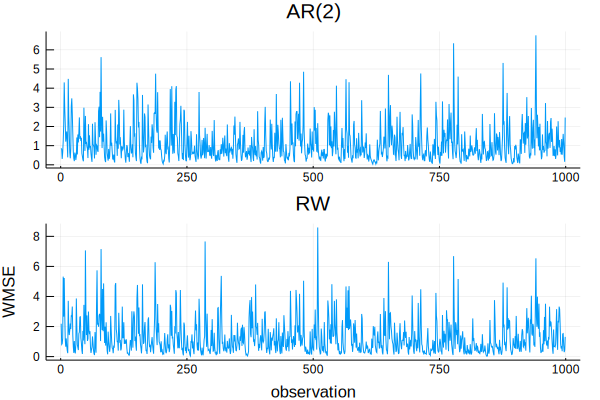

In [98]:
# Plotting
using Plots
pAR = plot(WMSEs, title="AR($ARorder)", label="")
pRW = plot(WMSEsRW, xlabel="observation", ylabel="WMSE", title="RW", label="")
plot(pAR, pRW, layout=(2,1))

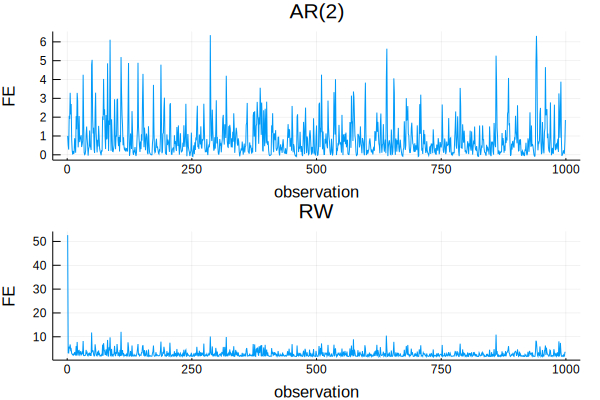

In [106]:
# Free energy
using Plots
pRW = plot(FRW, title="RW", xlabel="observation", ylabel="FE", label="")
pAR = plot(FAR, title="AR($ARorder)", xlabel="observation", ylabel="FE", label="")
plot(pAR, pRW, layout=(2,1))

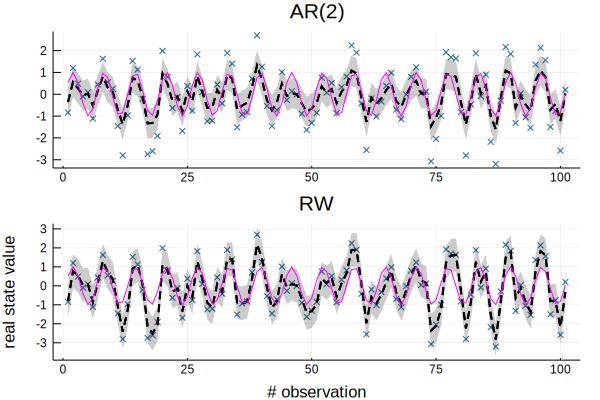

In [103]:
from = 300
upto = 400 # limit for building a graph 
scale = 1.0 # scale for the variance
v_x = [v_x[1]^-1 for v_x in precisionsRW[1:end]] # variances of estimated state
scatter(noise[from:upto], label="noisy observations", 
        markershape = :xcross, markeralpha = 0.6,
        markersize = 2)
plot!([meansRW[from:upto], meansRW[from:upto]], fillrange=[meansRW[from:upto] -
      scale .* sqrt.(v_x[from:upto]), meansRW[from:upto] +
      scale .* sqrt.(v_x[from:upto])],
      linestyle=:dash,linewidth = 2,
      color=:black,
      fillalpha = 0.2,
      fillcolor = :black,
      label=["inferred", "inferred"])
plot!(realRW[from:upto], color = :magenta, linewidth = 1.0, label="real state")
pRW = plot!(xlabel="# observation", ylabel="real state value", title="RW")


v_x = [v_x[1]^-1 for v_x in precisionsAR[1:end]] # variances of estimated state
scatter(noise[from:upto], label="noisy observations", 
        markershape = :xcross, markeralpha = 0.6,
        markersize = 2)
plot!([meansAR[from:upto], meansAR[from:upto]], fillrange=[meansAR[from:upto] -
      scale .* sqrt.(v_x[from:upto]), meansAR[from:upto] +
      scale .* sqrt.(v_x[from:upto])],
      linestyle=:dash,linewidth = 2,
      color=:black,
      fillalpha = 0.2,
      fillcolor = :black,
      label=["inferred", "inferred"])
plot!(realAR[from:upto], color = :magenta, linewidth = 1.0, label="real state")
pAR = plot!(title="AR($ARorder)", legend=false)

plot(pAR, pRW, layout=(2,1), legend=false)

In [104]:
sum(WMSEs)

1116.814894769996

In [105]:
sum(WMSEsRW)

1291.5710926160207